# Diagnostics: Overlap and Effective Sample Size

We compute overlap diagnostics and visualize effective sample size to assess
weight stability before trusting OPE estimates.

In [1]:
from __future__ import annotations

from pathlib import Path

import numpy as np

from crl.benchmarks.mdp_synth import SyntheticMDP, SyntheticMDPConfig
from crl.core import Diagnostics
from crl.diagnostics import (
    compute_overlap_metrics,
    effective_sample_size,
    ess_ratio,
    state_shift_diagnostics,
    weight_tail_stats,
    weight_time_diagnostics,
)
from crl.estimators.utils import compute_action_probs
from crl.viz import (
    FigureSpec,
    apply_axes_style,
    configure_notebook_display,
    journal_style,
    new_figure,
    paper_context,
    paper_figspec,
    save_figure,
    set_style,
)
from crl.viz.plots import (
    plot_bias_variance_tradeoff,
    plot_effective_sample_size,
    plot_overlap_diagnostics,
)

In [2]:
np.random.seed(0)
configure_notebook_display()

benchmark = SyntheticMDP(SyntheticMDPConfig(seed=3, horizon=6))
dataset = benchmark.sample(num_trajectories=400, seed=4)

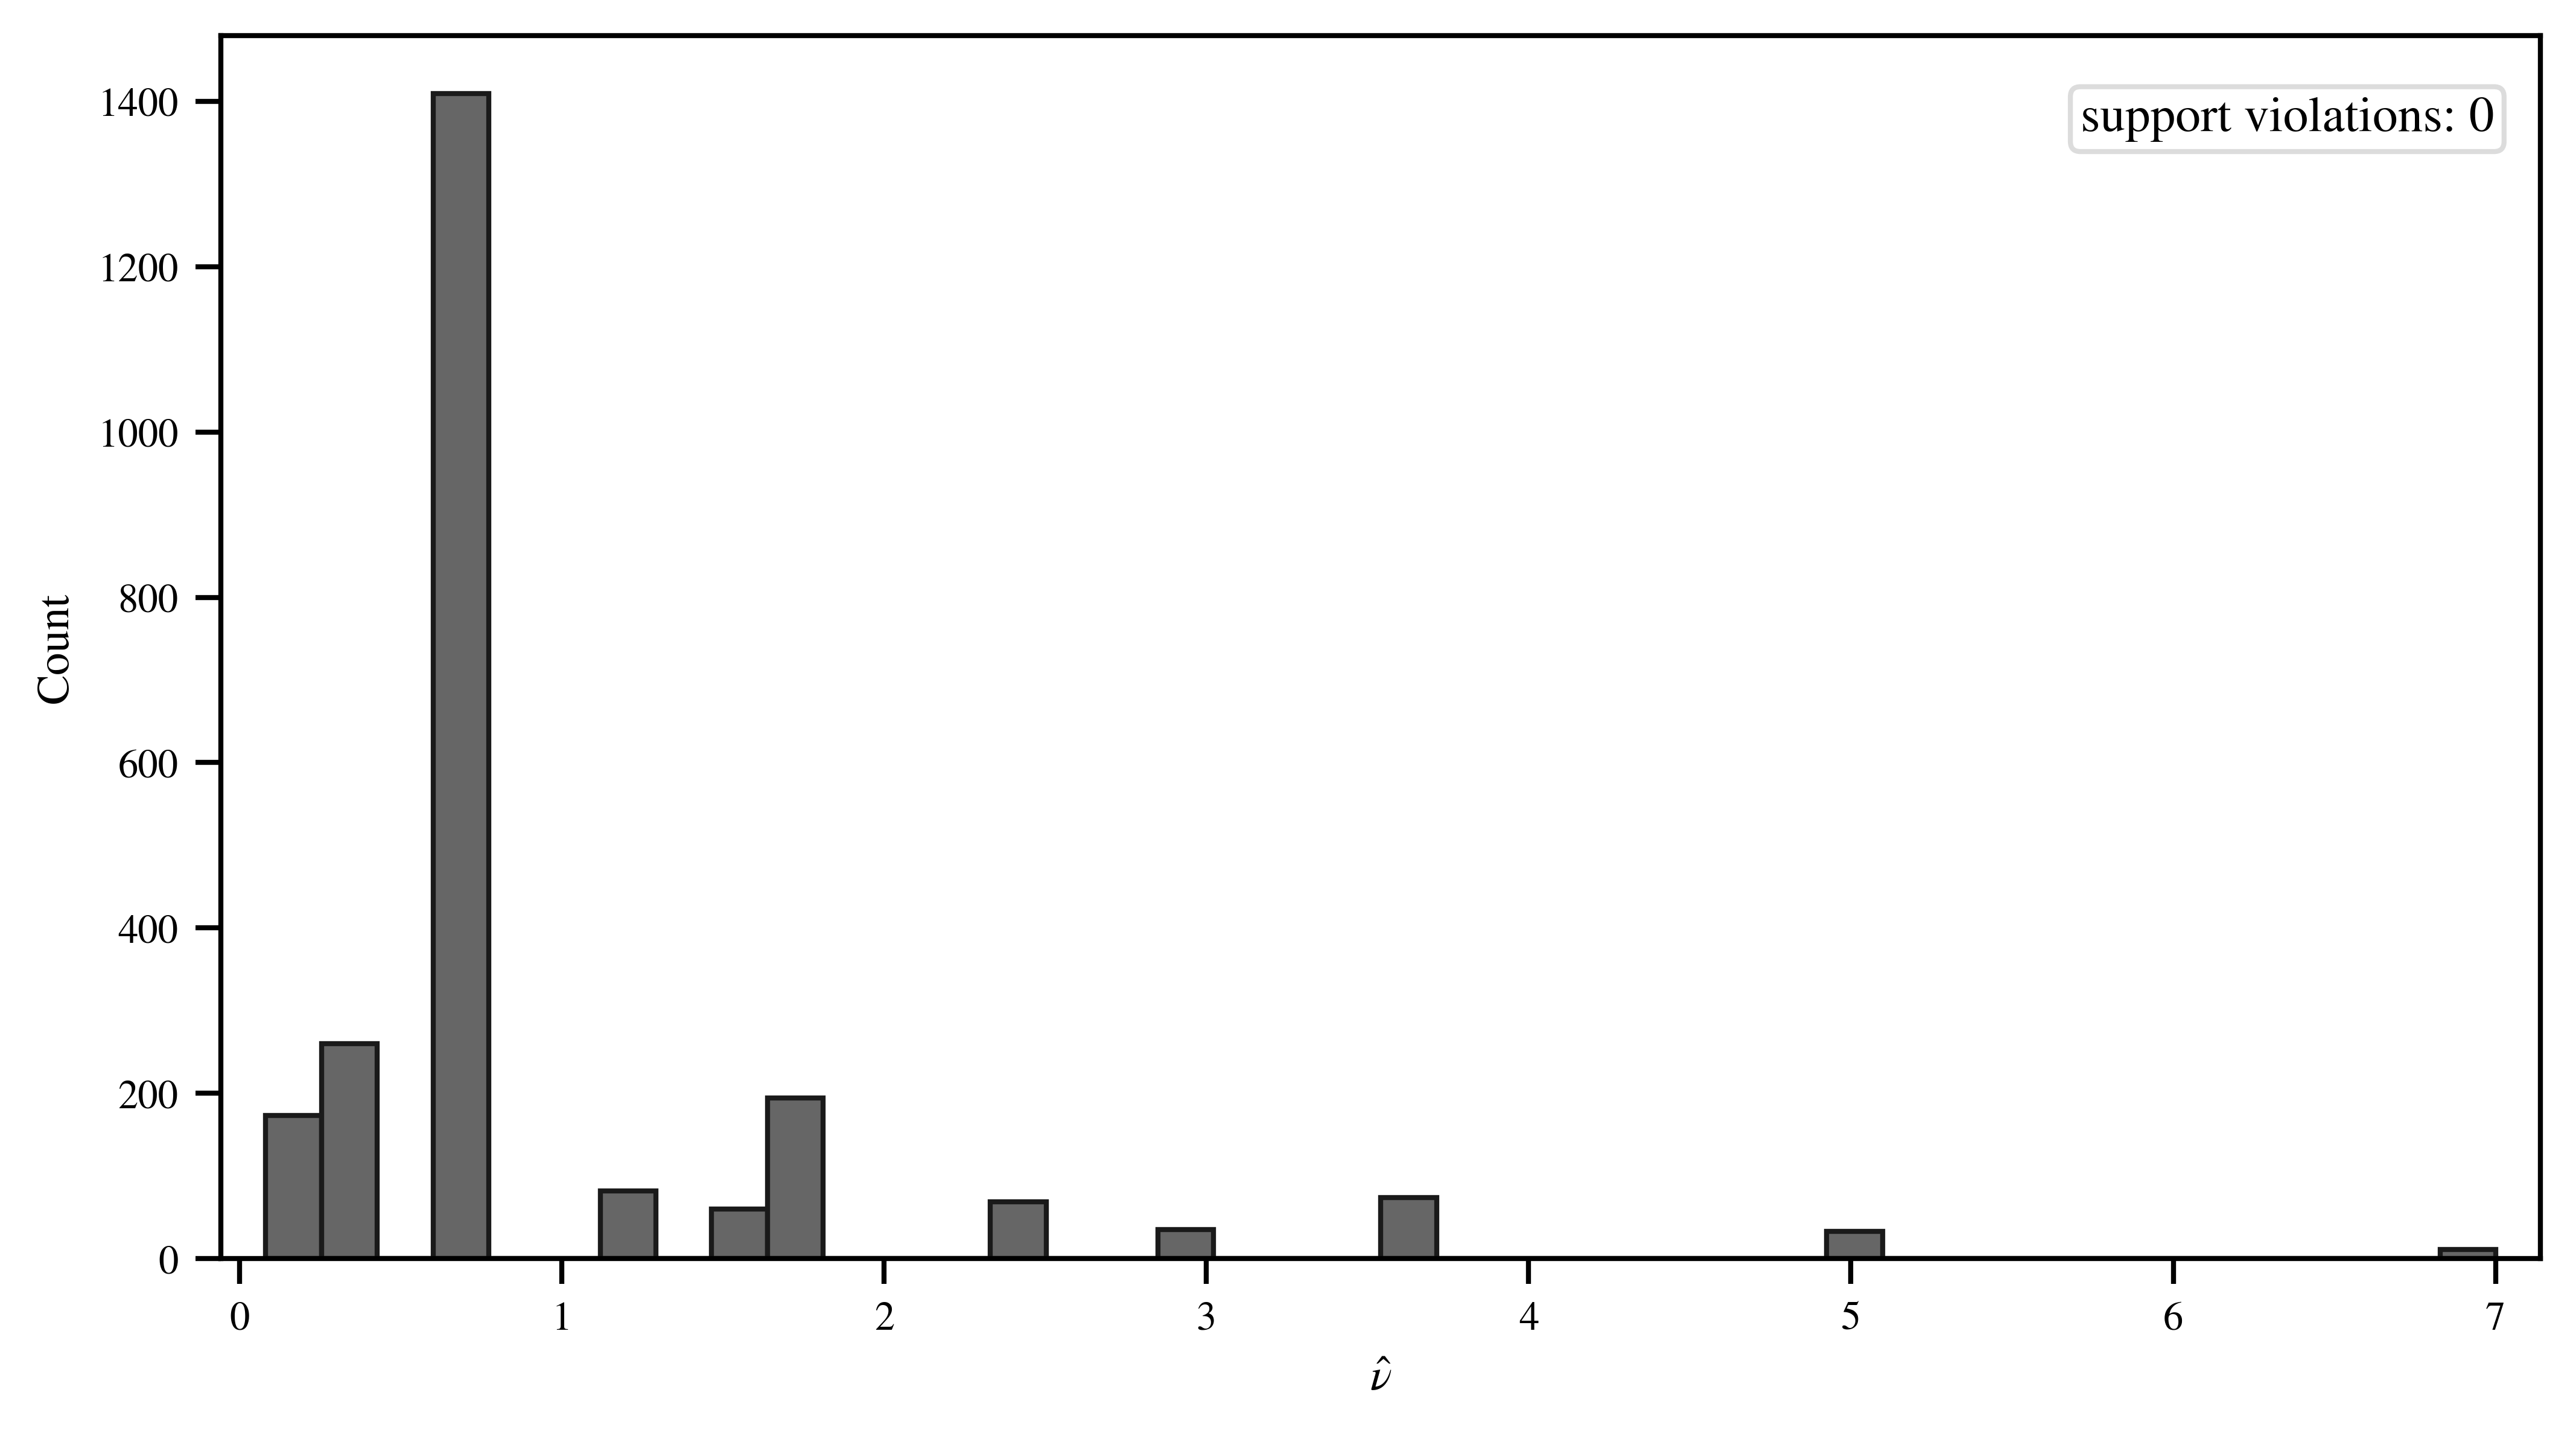

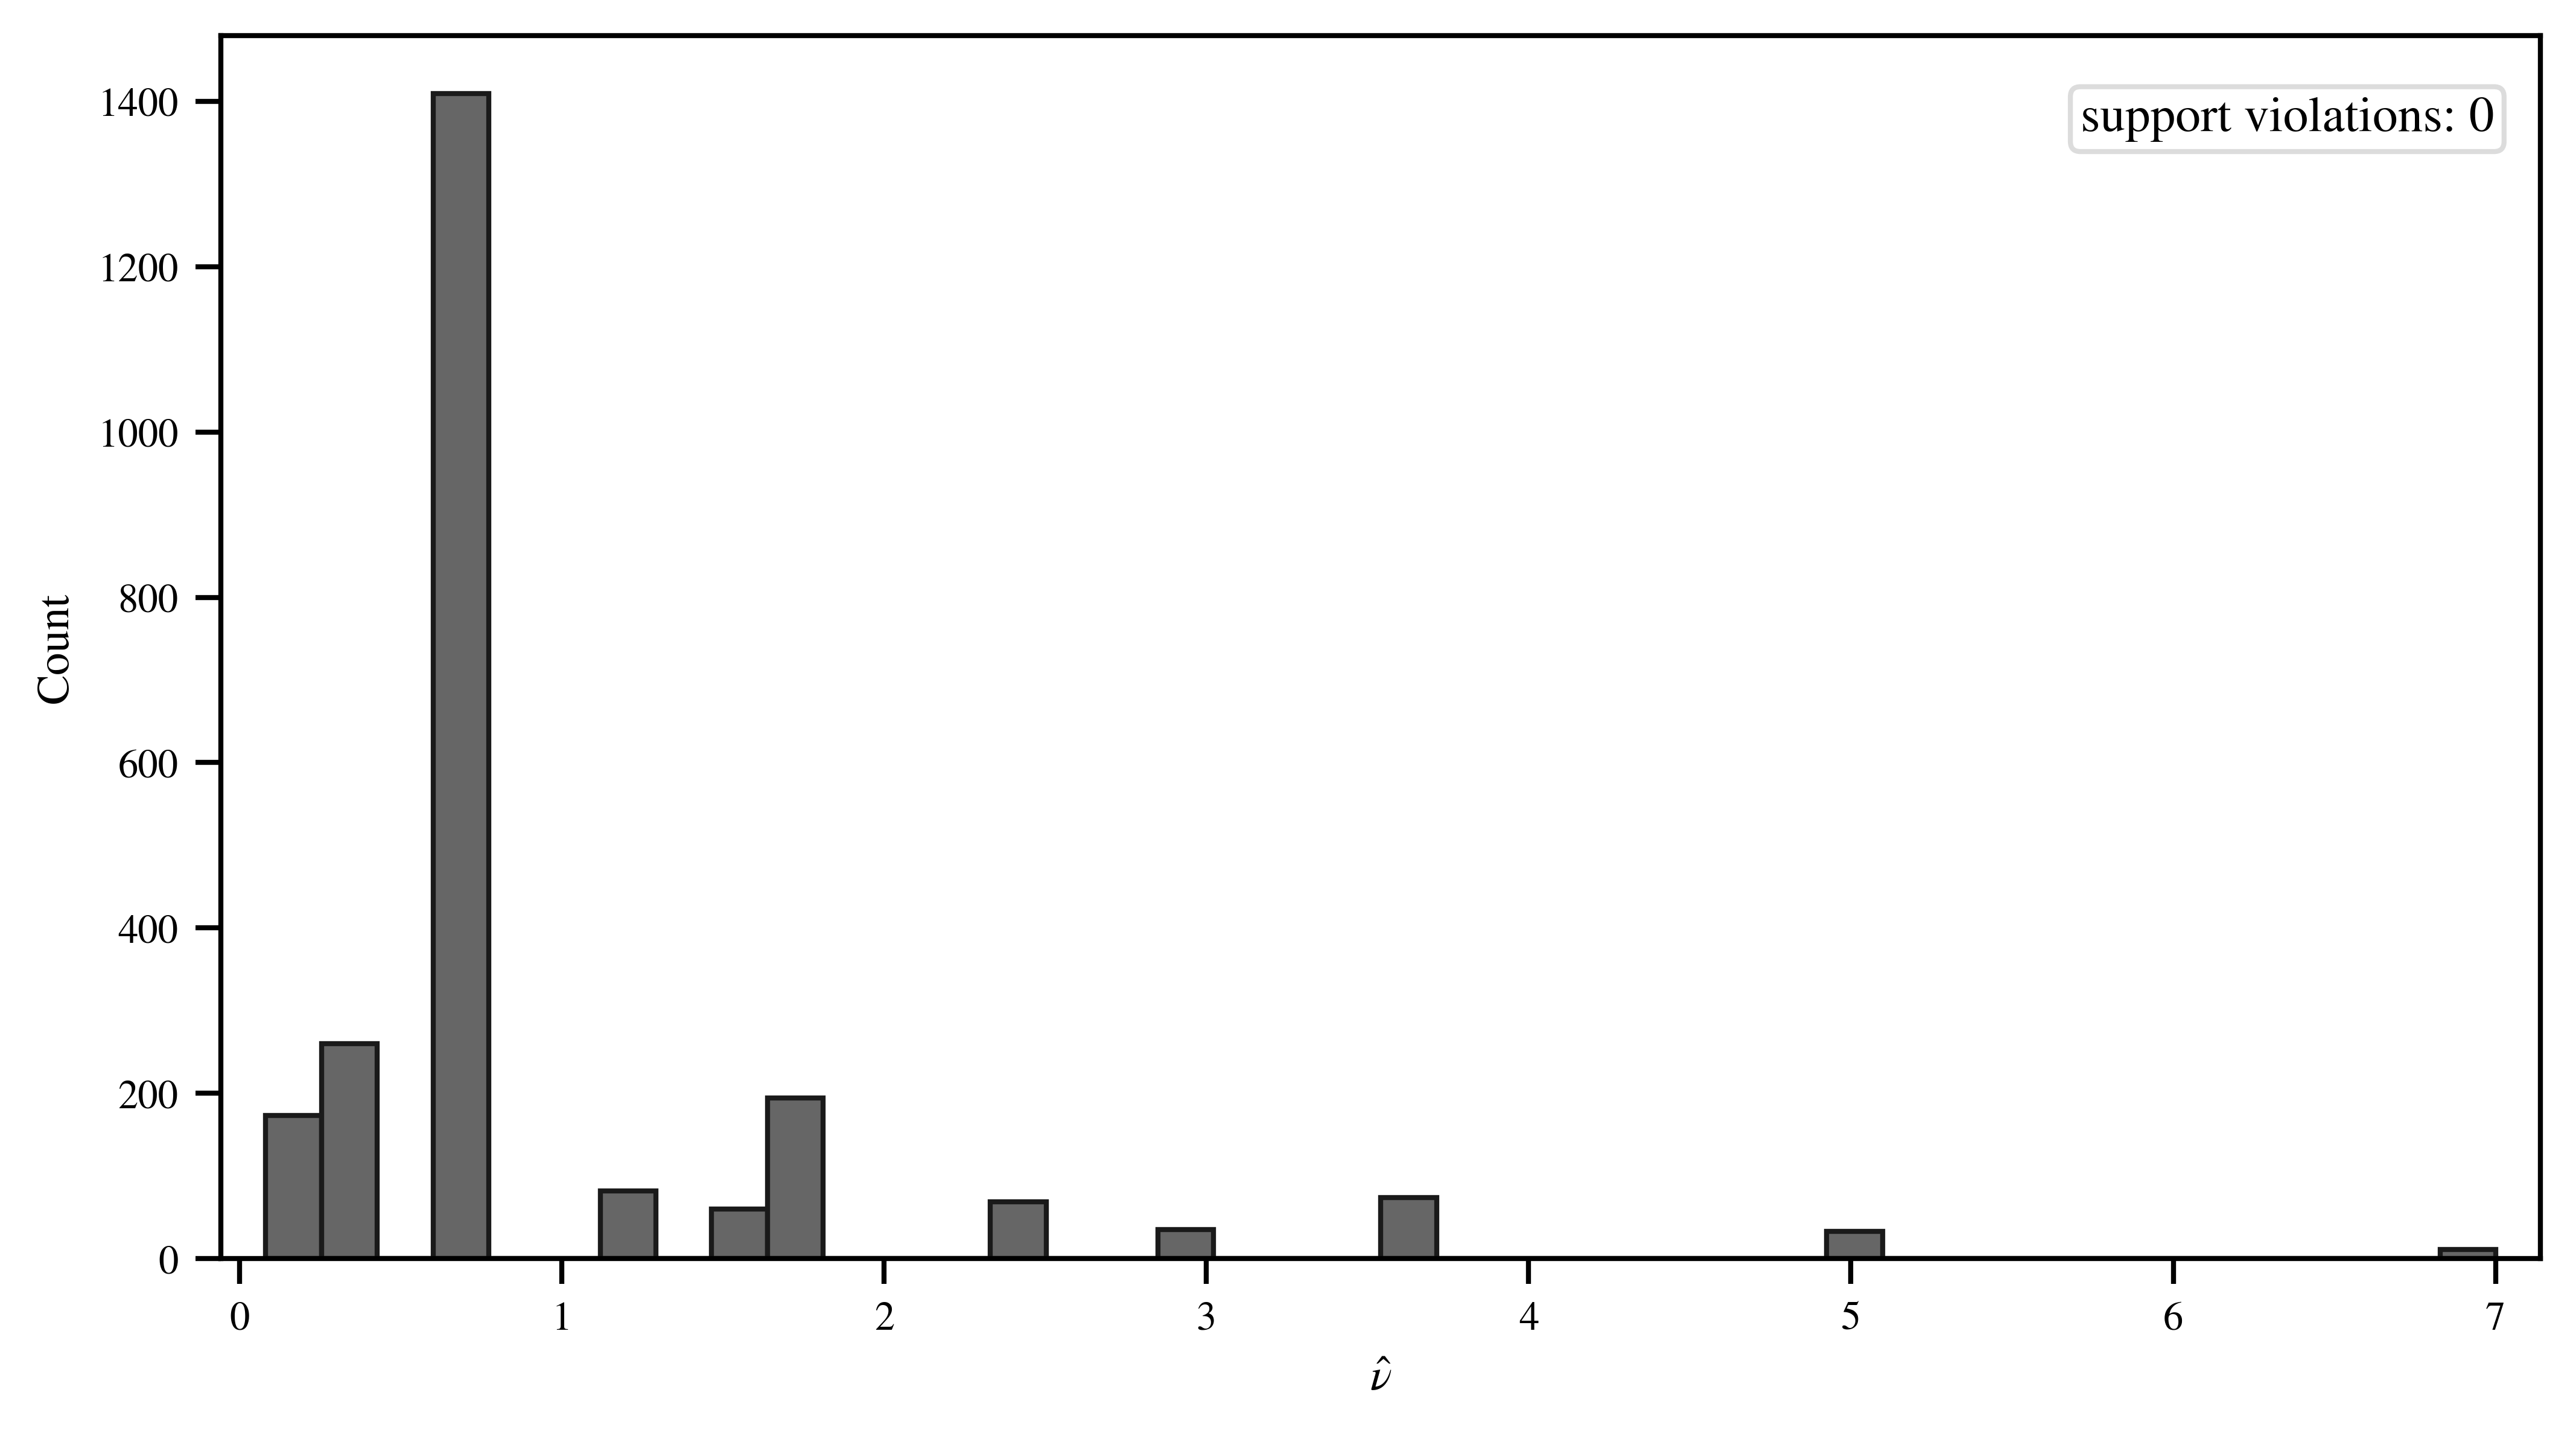

In [3]:
target_probs = compute_action_probs(
    benchmark.target_policy, dataset.observations, dataset.actions
)
ratios = np.where(dataset.mask, target_probs / dataset.behavior_action_probs, 1.0)
weights = np.prod(ratios, axis=1)

fig_overlap = plot_overlap_diagnostics(
    target_probs, dataset.behavior_action_probs, mask=dataset.mask
)
fig_overlap

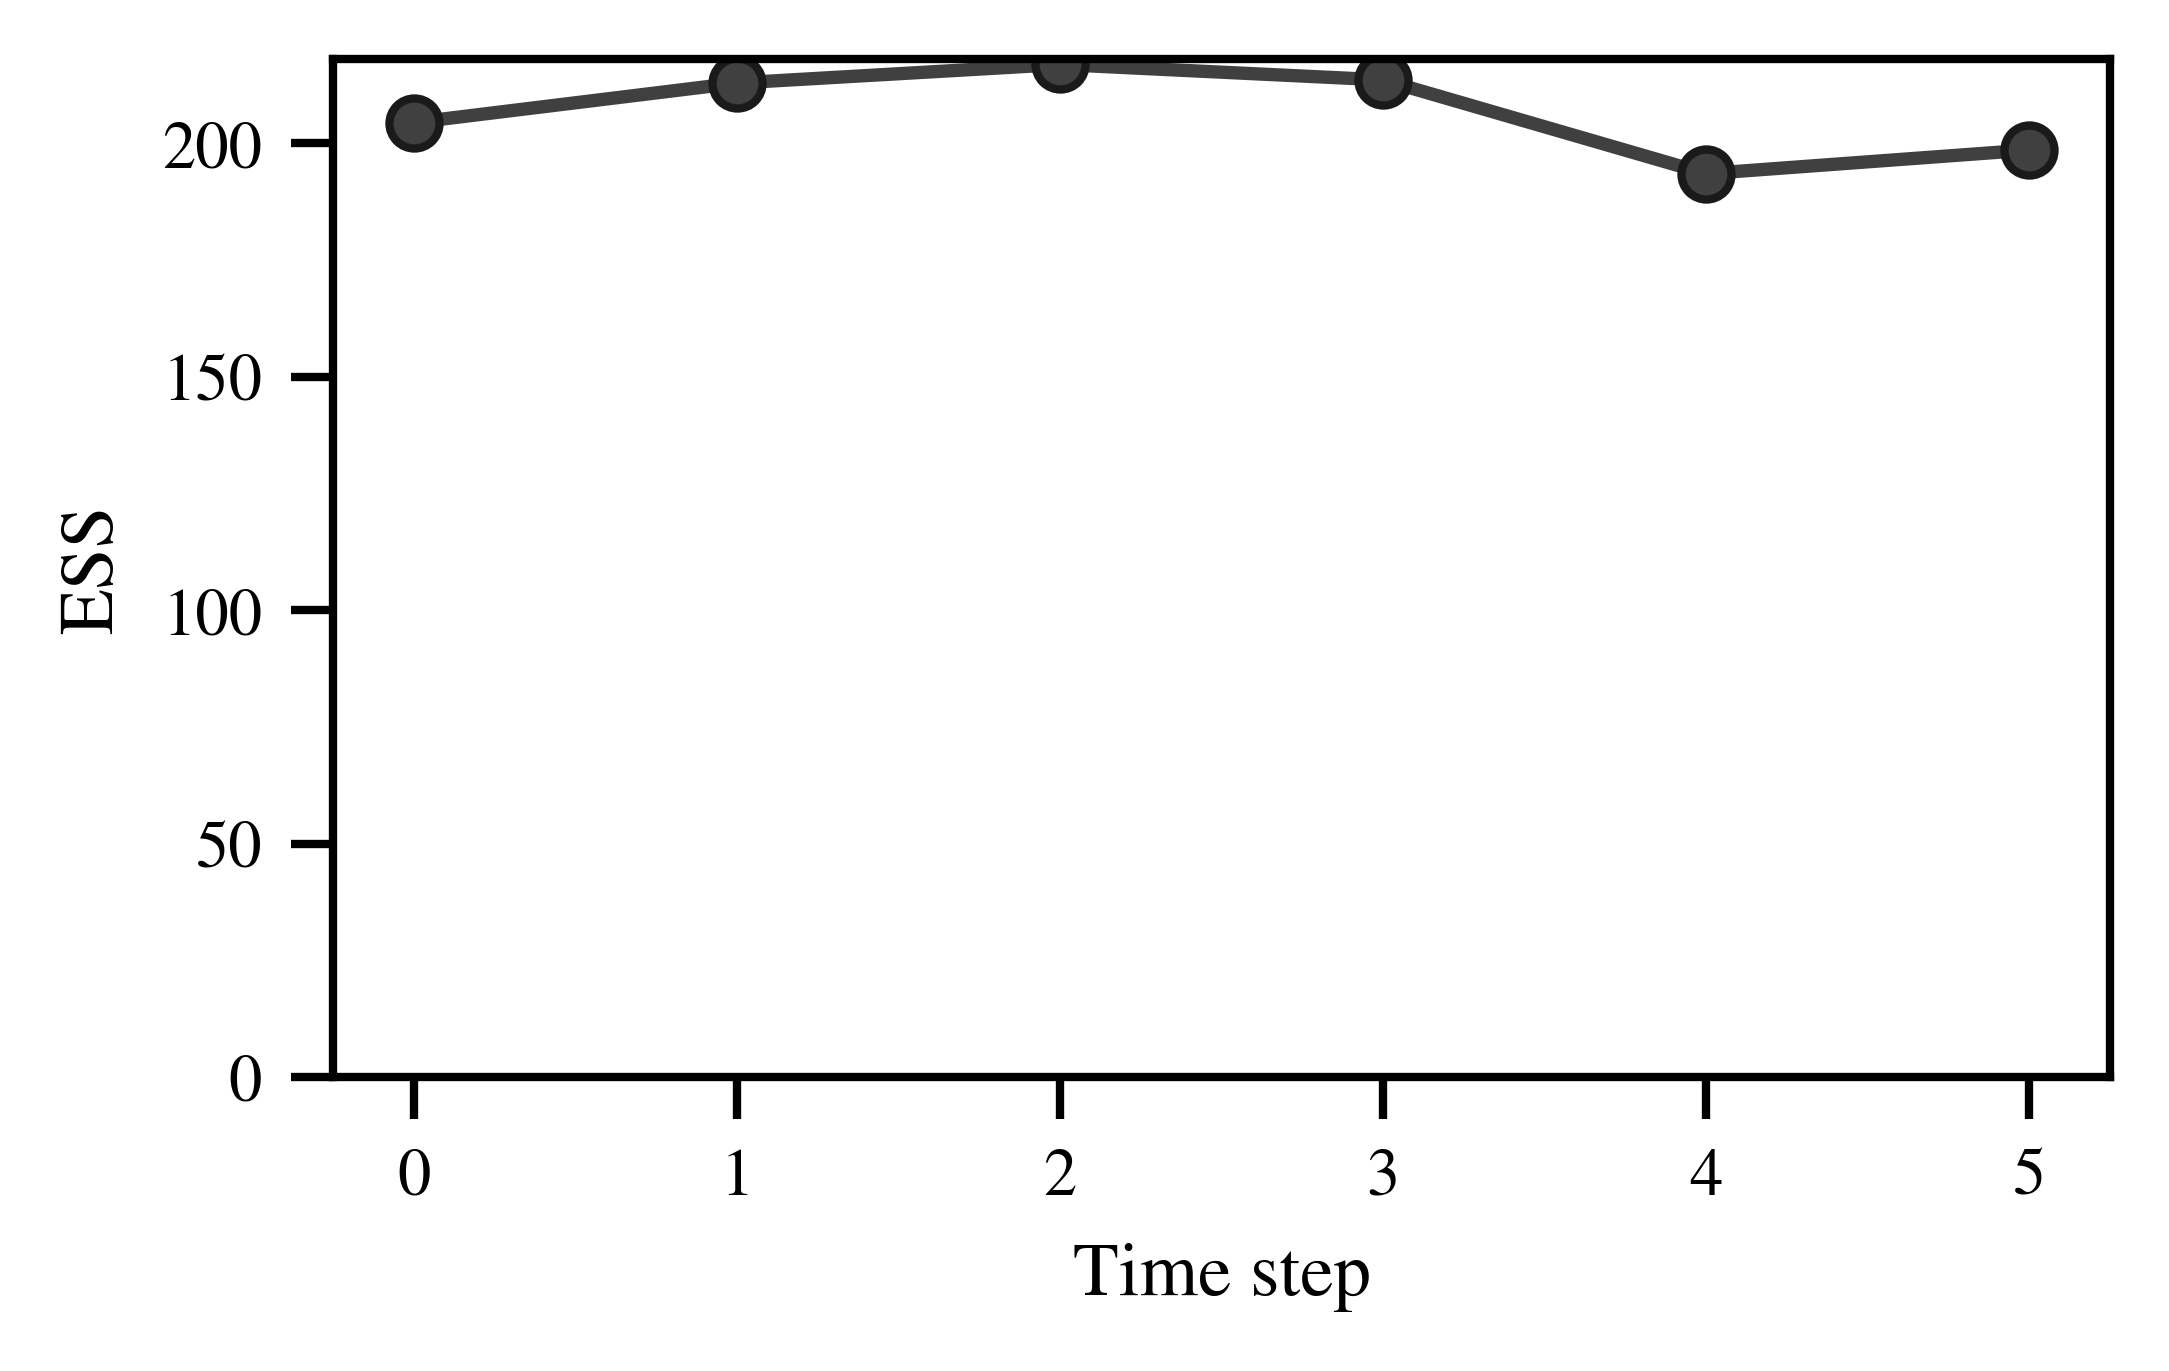

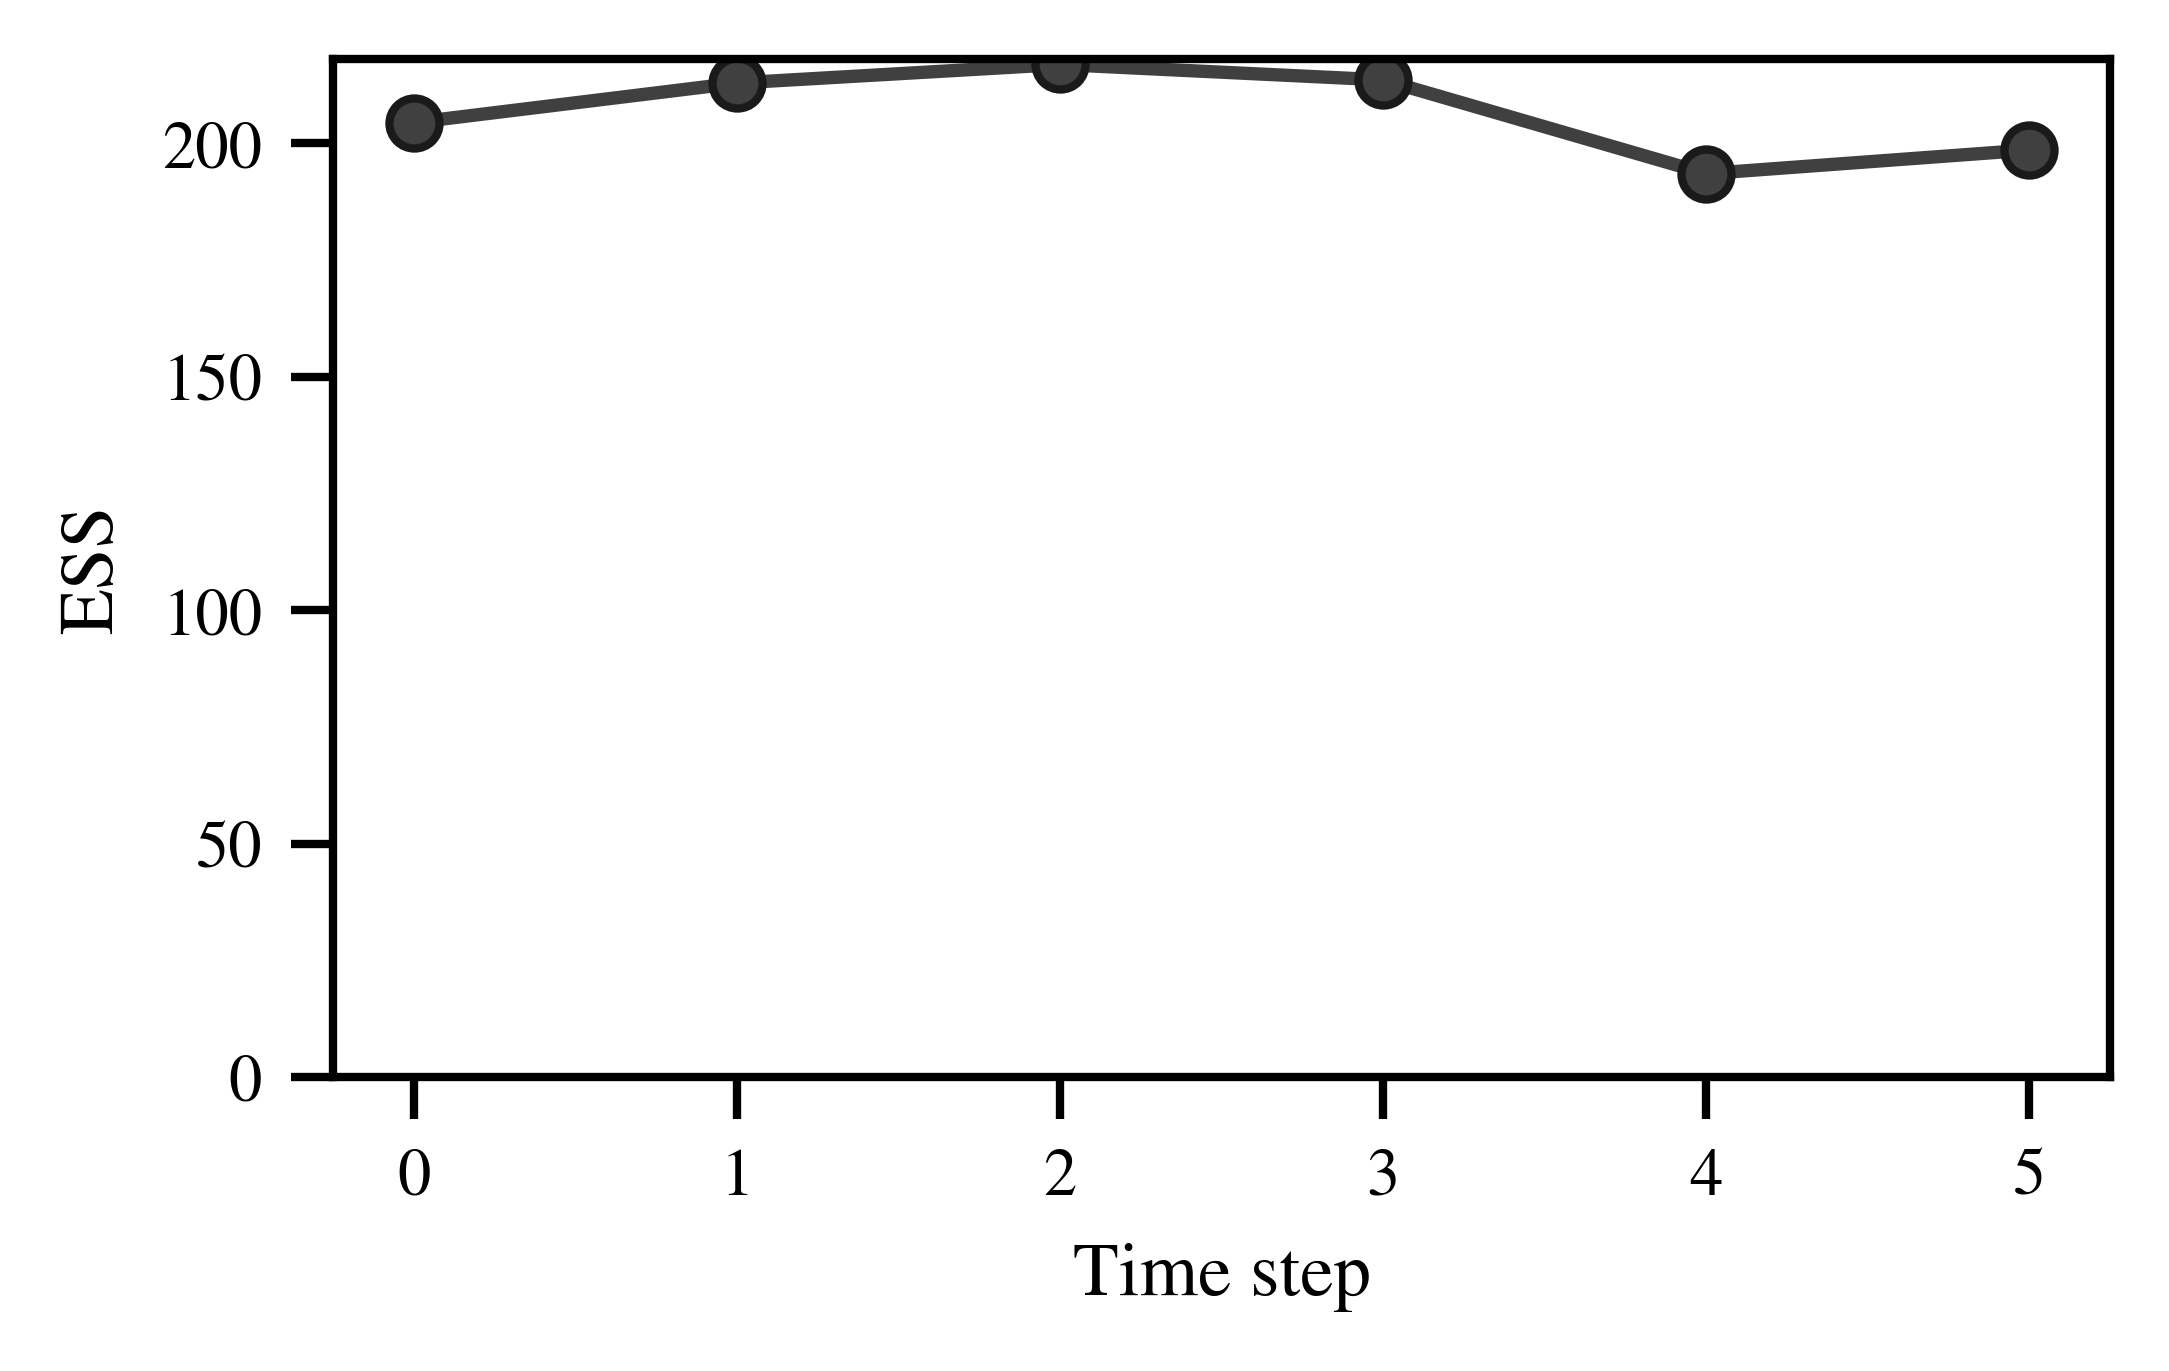

In [4]:
fig_ess = plot_effective_sample_size(ratios, by_time=True)
fig_ess

## Numeric diagnostics

The low-level diagnostics helpers return structured summaries you can log or
store alongside estimates.

In [5]:
overlap_metrics = compute_overlap_metrics(
    target_probs, dataset.behavior_action_probs, mask=dataset.mask
)
ess_value = effective_sample_size(weights)
ess_ratio_value = ess_ratio(weights)
tail_stats = weight_tail_stats(weights)
time_stats = weight_time_diagnostics(np.cumprod(ratios, axis=1), dataset.mask)
shift_stats = state_shift_diagnostics(dataset.observations[dataset.mask], weights=ratios[dataset.mask])

diagnostics_obj = Diagnostics(
    ess={"ess": ess_value, "ess_ratio": ess_ratio_value},
    overlap=overlap_metrics,
    weights=tail_stats,
    model={},
)
diagnostics_obj.to_dict(), shift_stats

({'ess': {'ess': 50.04419545430942, 'ess_ratio': 0.12511048863577354},
  'overlap': {'min_behavior_prob': 0.043794675616241084,
   'min_target_prob': 0.03992160148790039,
   'fraction_behavior_below_threshold': 0.0,
   'fraction_target_below_threshold': 0.0,
   'ratio_min': 0.08090446596264117,
   'ratio_max': 7.000903169547911,
   'ratio_q50': 0.6764057036543533,
   'ratio_q90': 1.7665923246463542,
   'ratio_q99': 5.0584323788712044,
   'support_violations': 0},
  'weights': {'min': 0.00028391571525808863,
   'max': 15.554282792677004,
   'mean': 0.6772724142475091,
   'std': 1.7909898793975325,
   'q95': 2.356862899236809,
   'q99': 10.256042355165583,
   'skew': 5.105389883420246,
   'kurtosis': 29.131149831656074,
   'tail_fraction': 0.015},
  'model': {}},
 {'mmd_rbf': 0.002243172611438915,
  'mean_shift_norm': 0.07459068830649951,
  'cov_shift_fro': 0.041684405817693726,
  'ess': 1238.1964760126036})

## Bias-variance tradeoff plot

This plot is useful for comparing estimator families when repeated runs or
benchmark suites provide bias and variance estimates.

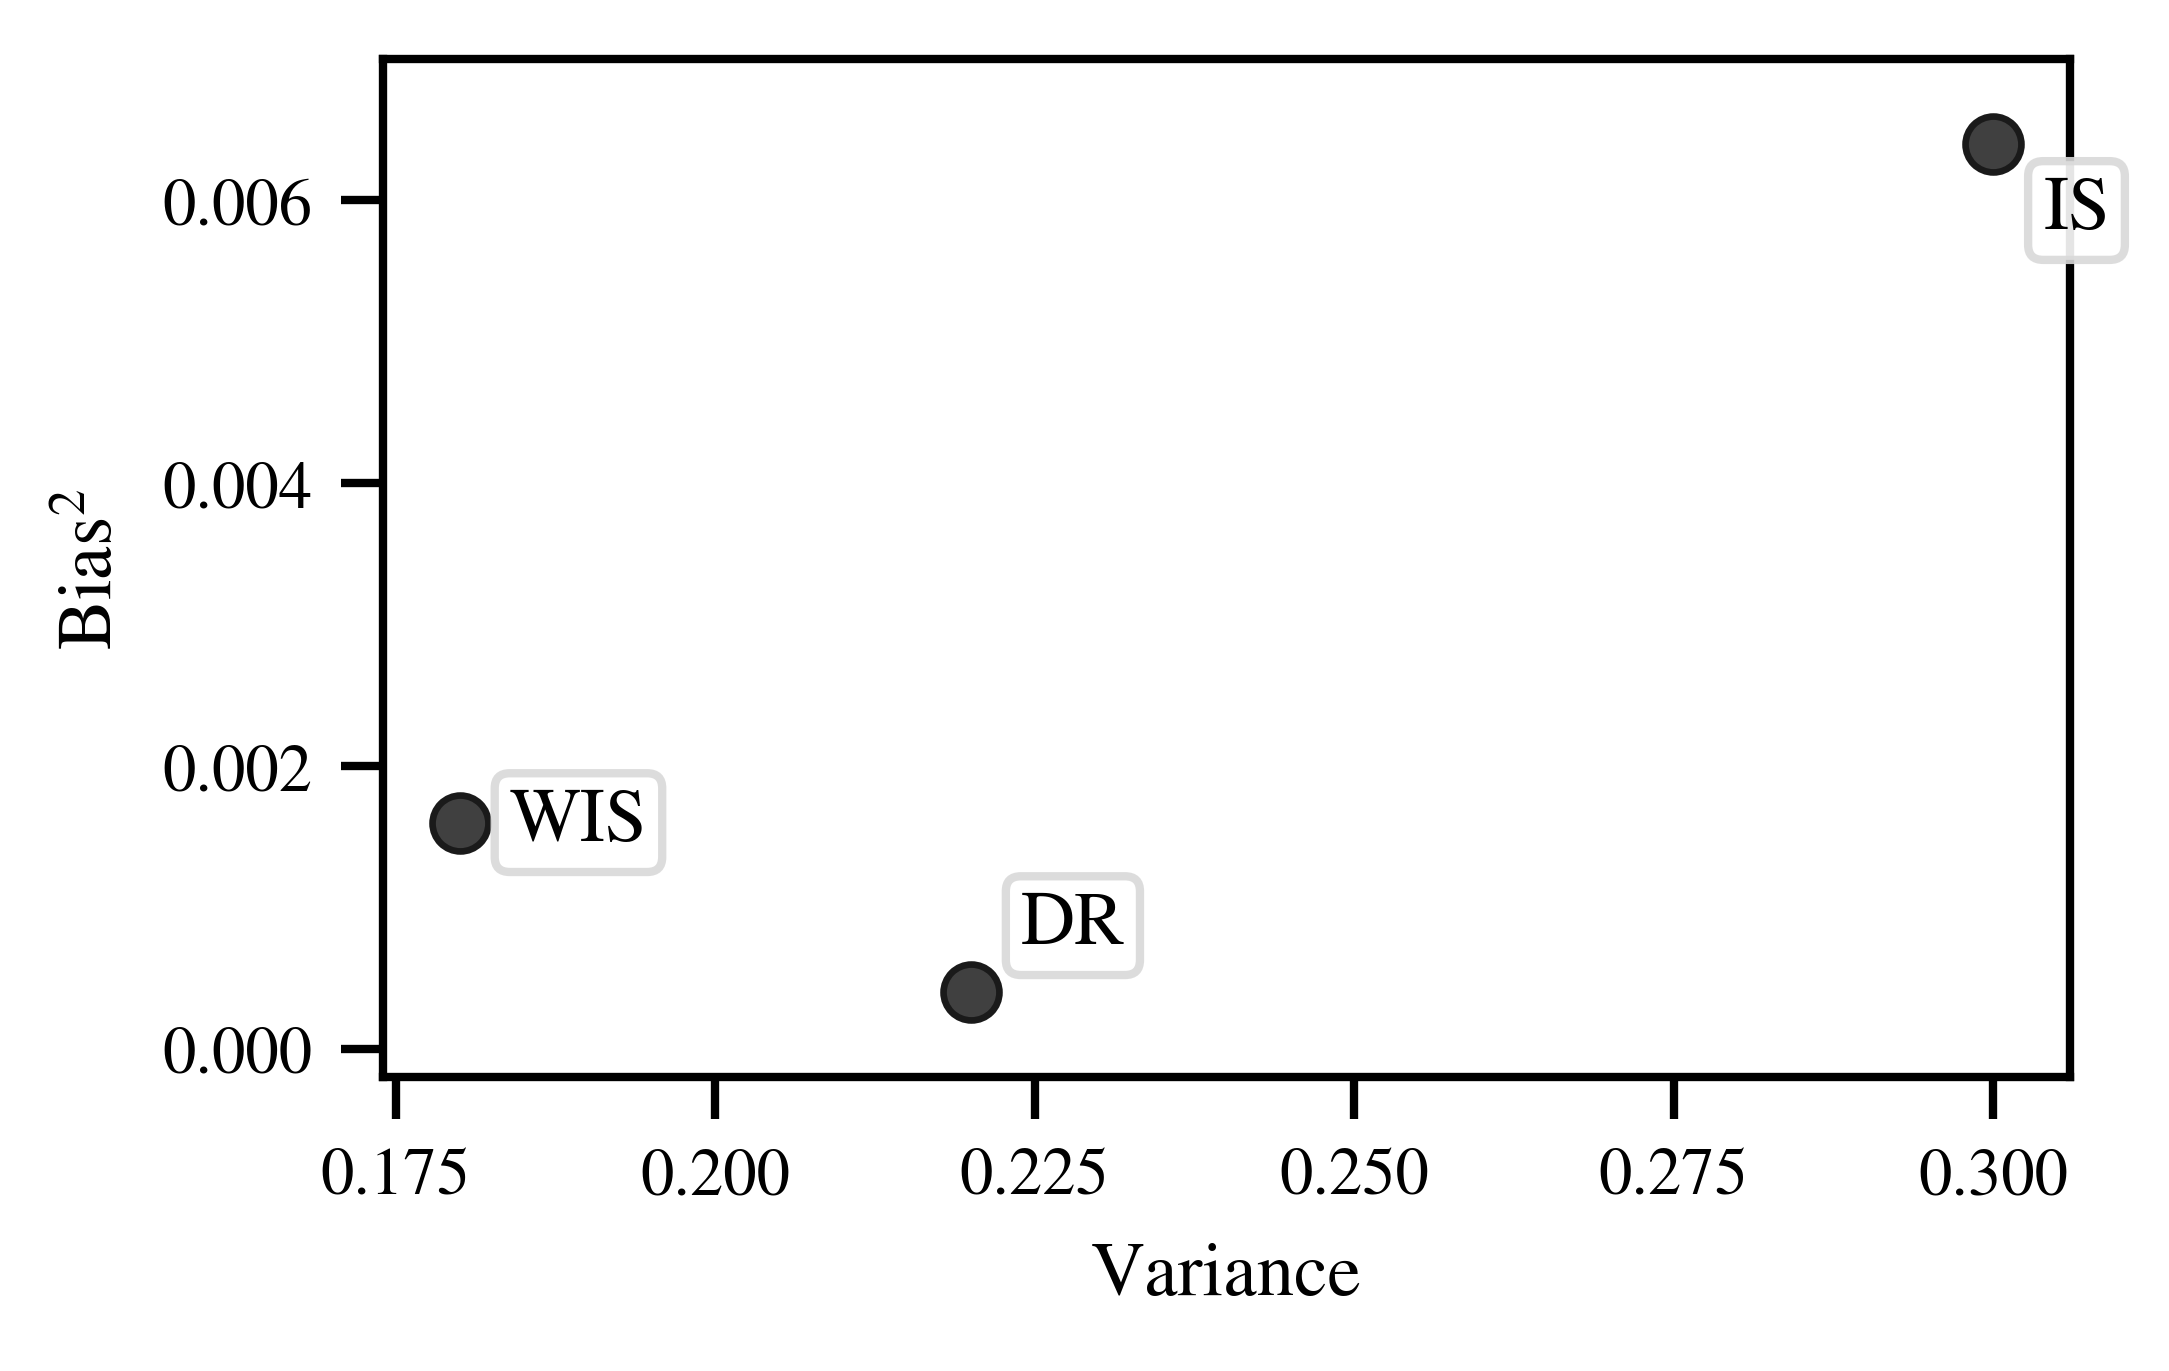

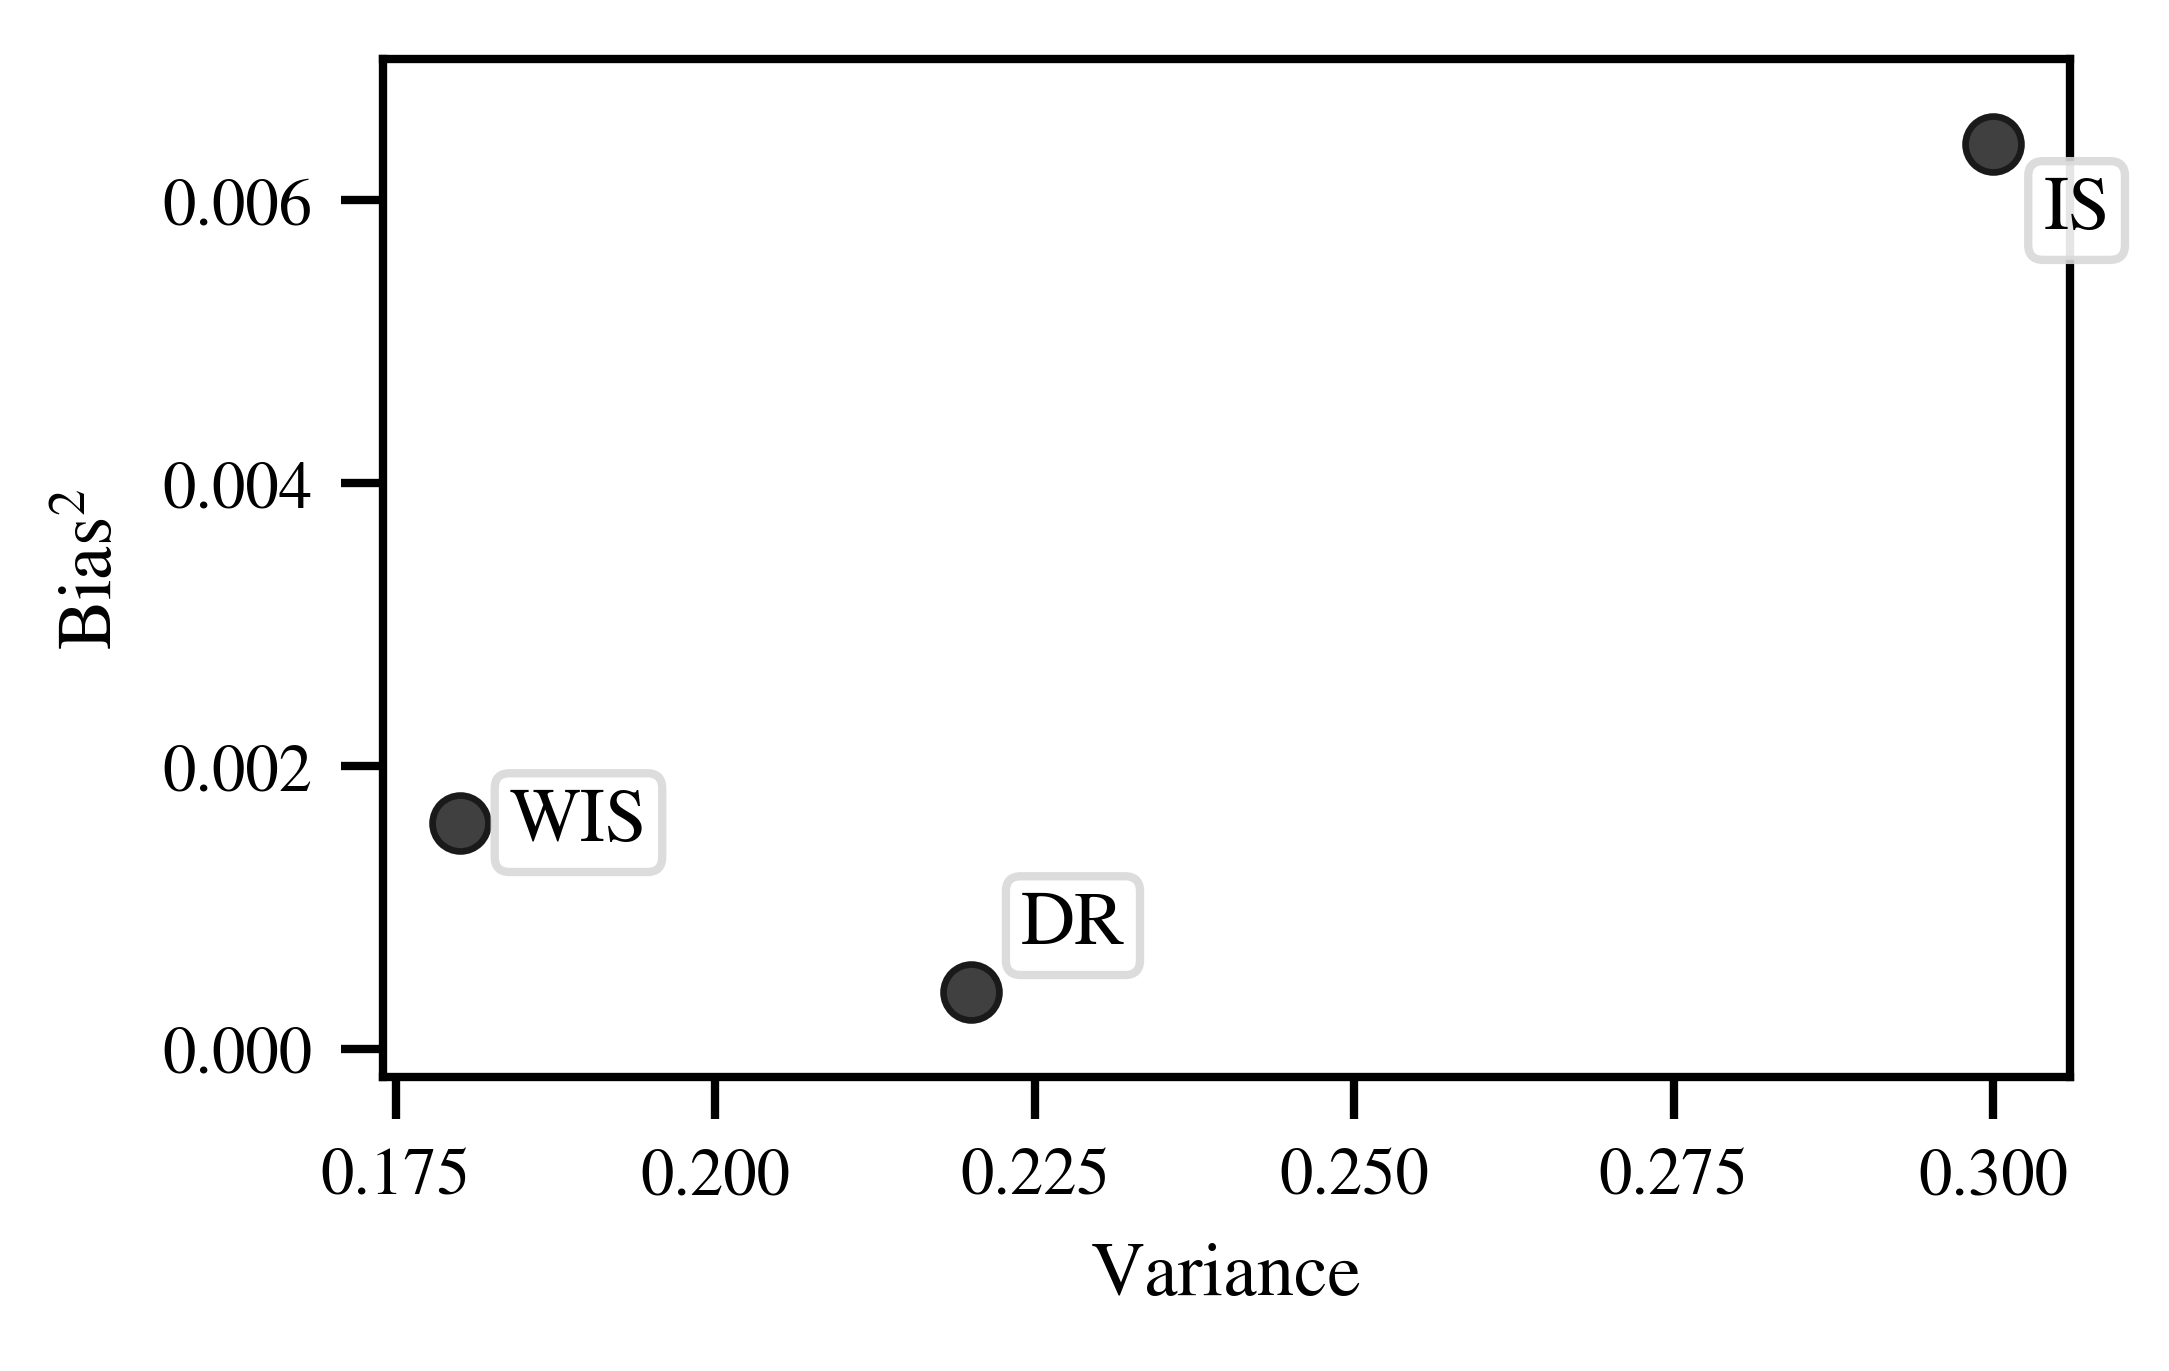

In [6]:
trade_rows = [
    {"estimator": "IS", "bias": 0.08, "variance": 0.30},
    {"estimator": "WIS", "bias": 0.04, "variance": 0.18},
    {"estimator": "DR", "bias": 0.02, "variance": 0.22},
]
fig_trade = plot_bias_variance_tradeoff(trade_rows)
fig_trade

## Styling utilities

The style helpers allow you to build consistent, paper-ready figures. Here we
create a custom ESS plot using the raw diagnostics output.

(<Figure size 1050x577.5 with 1 Axes>, <Figure size 1080x660 with 1 Axes>)

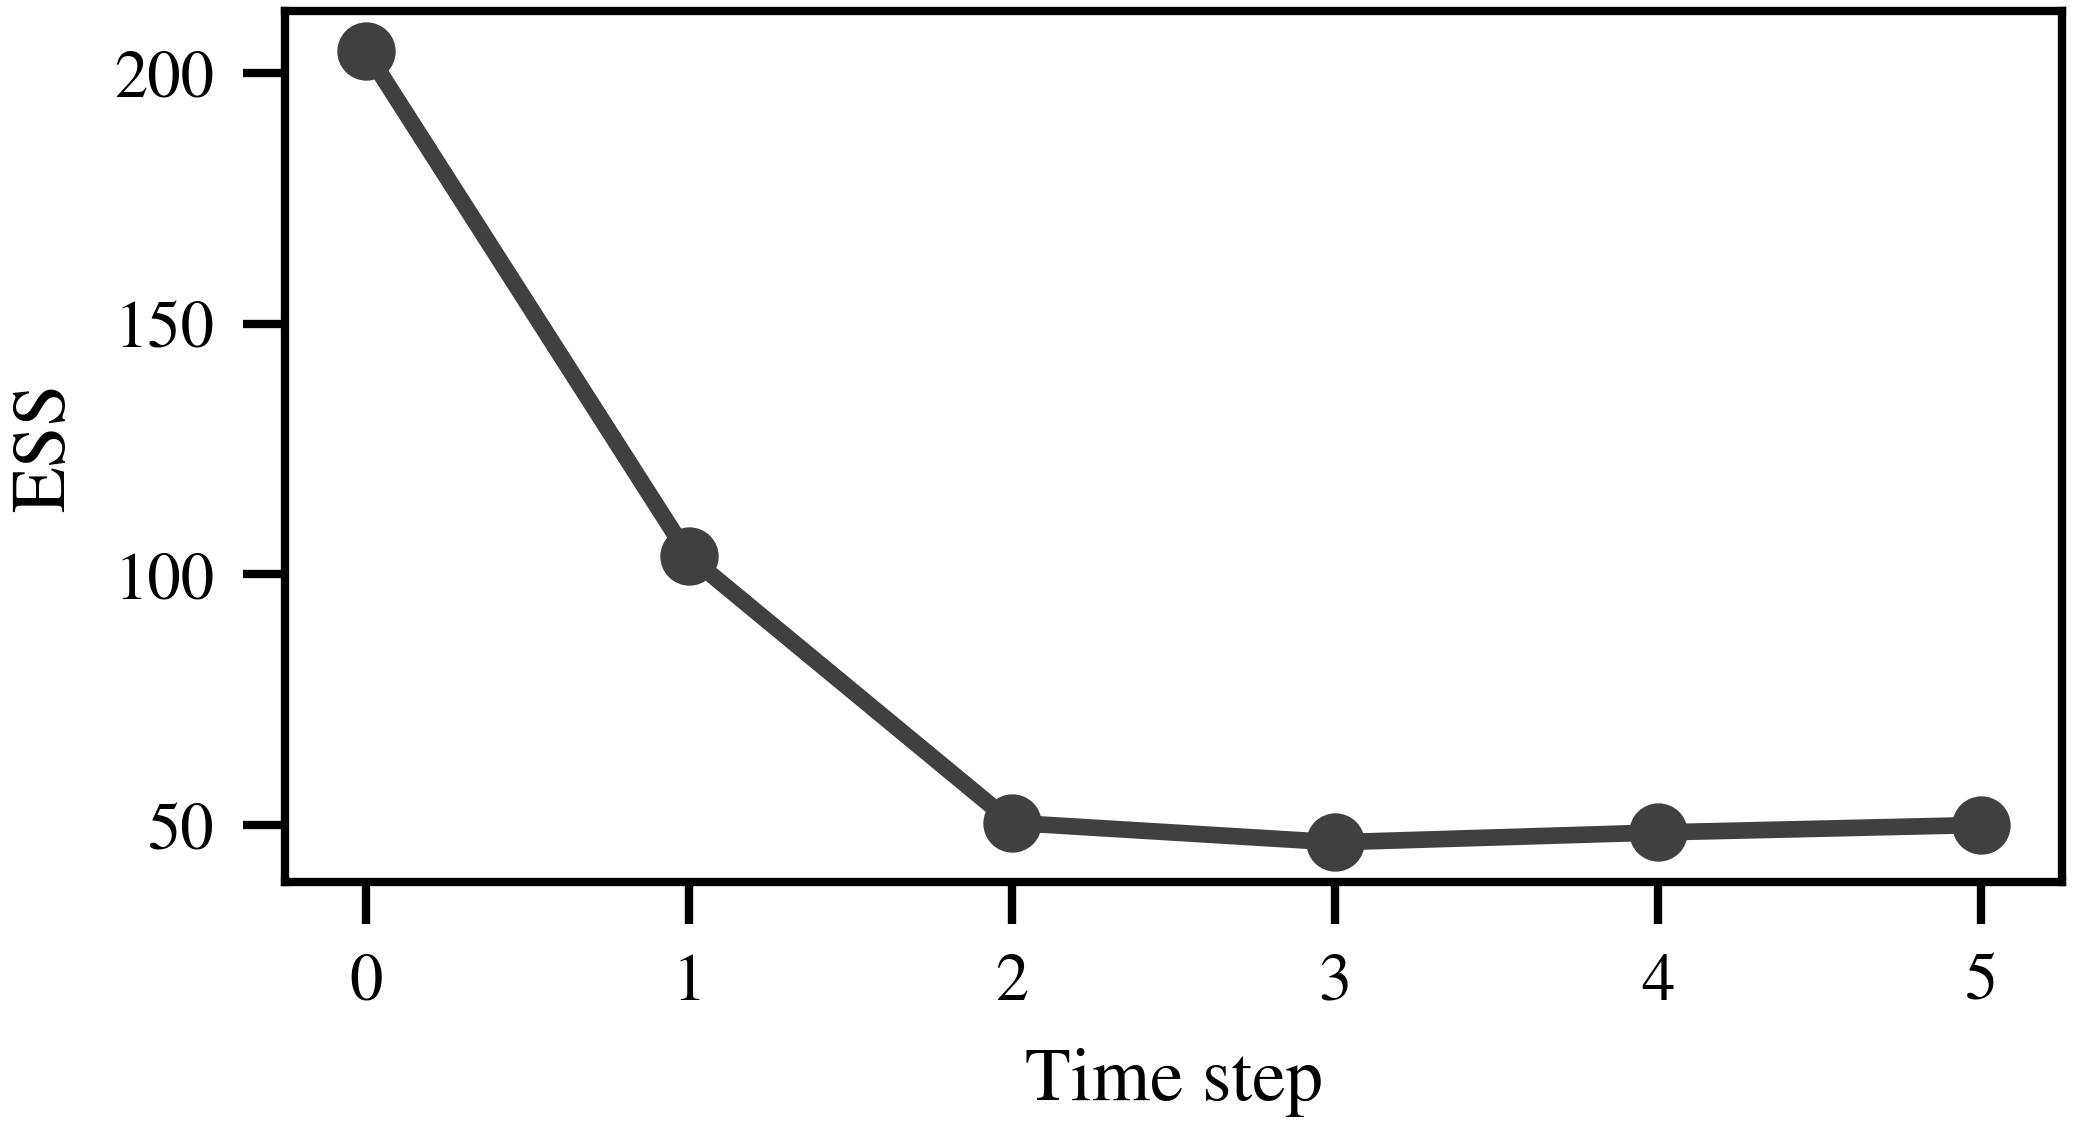

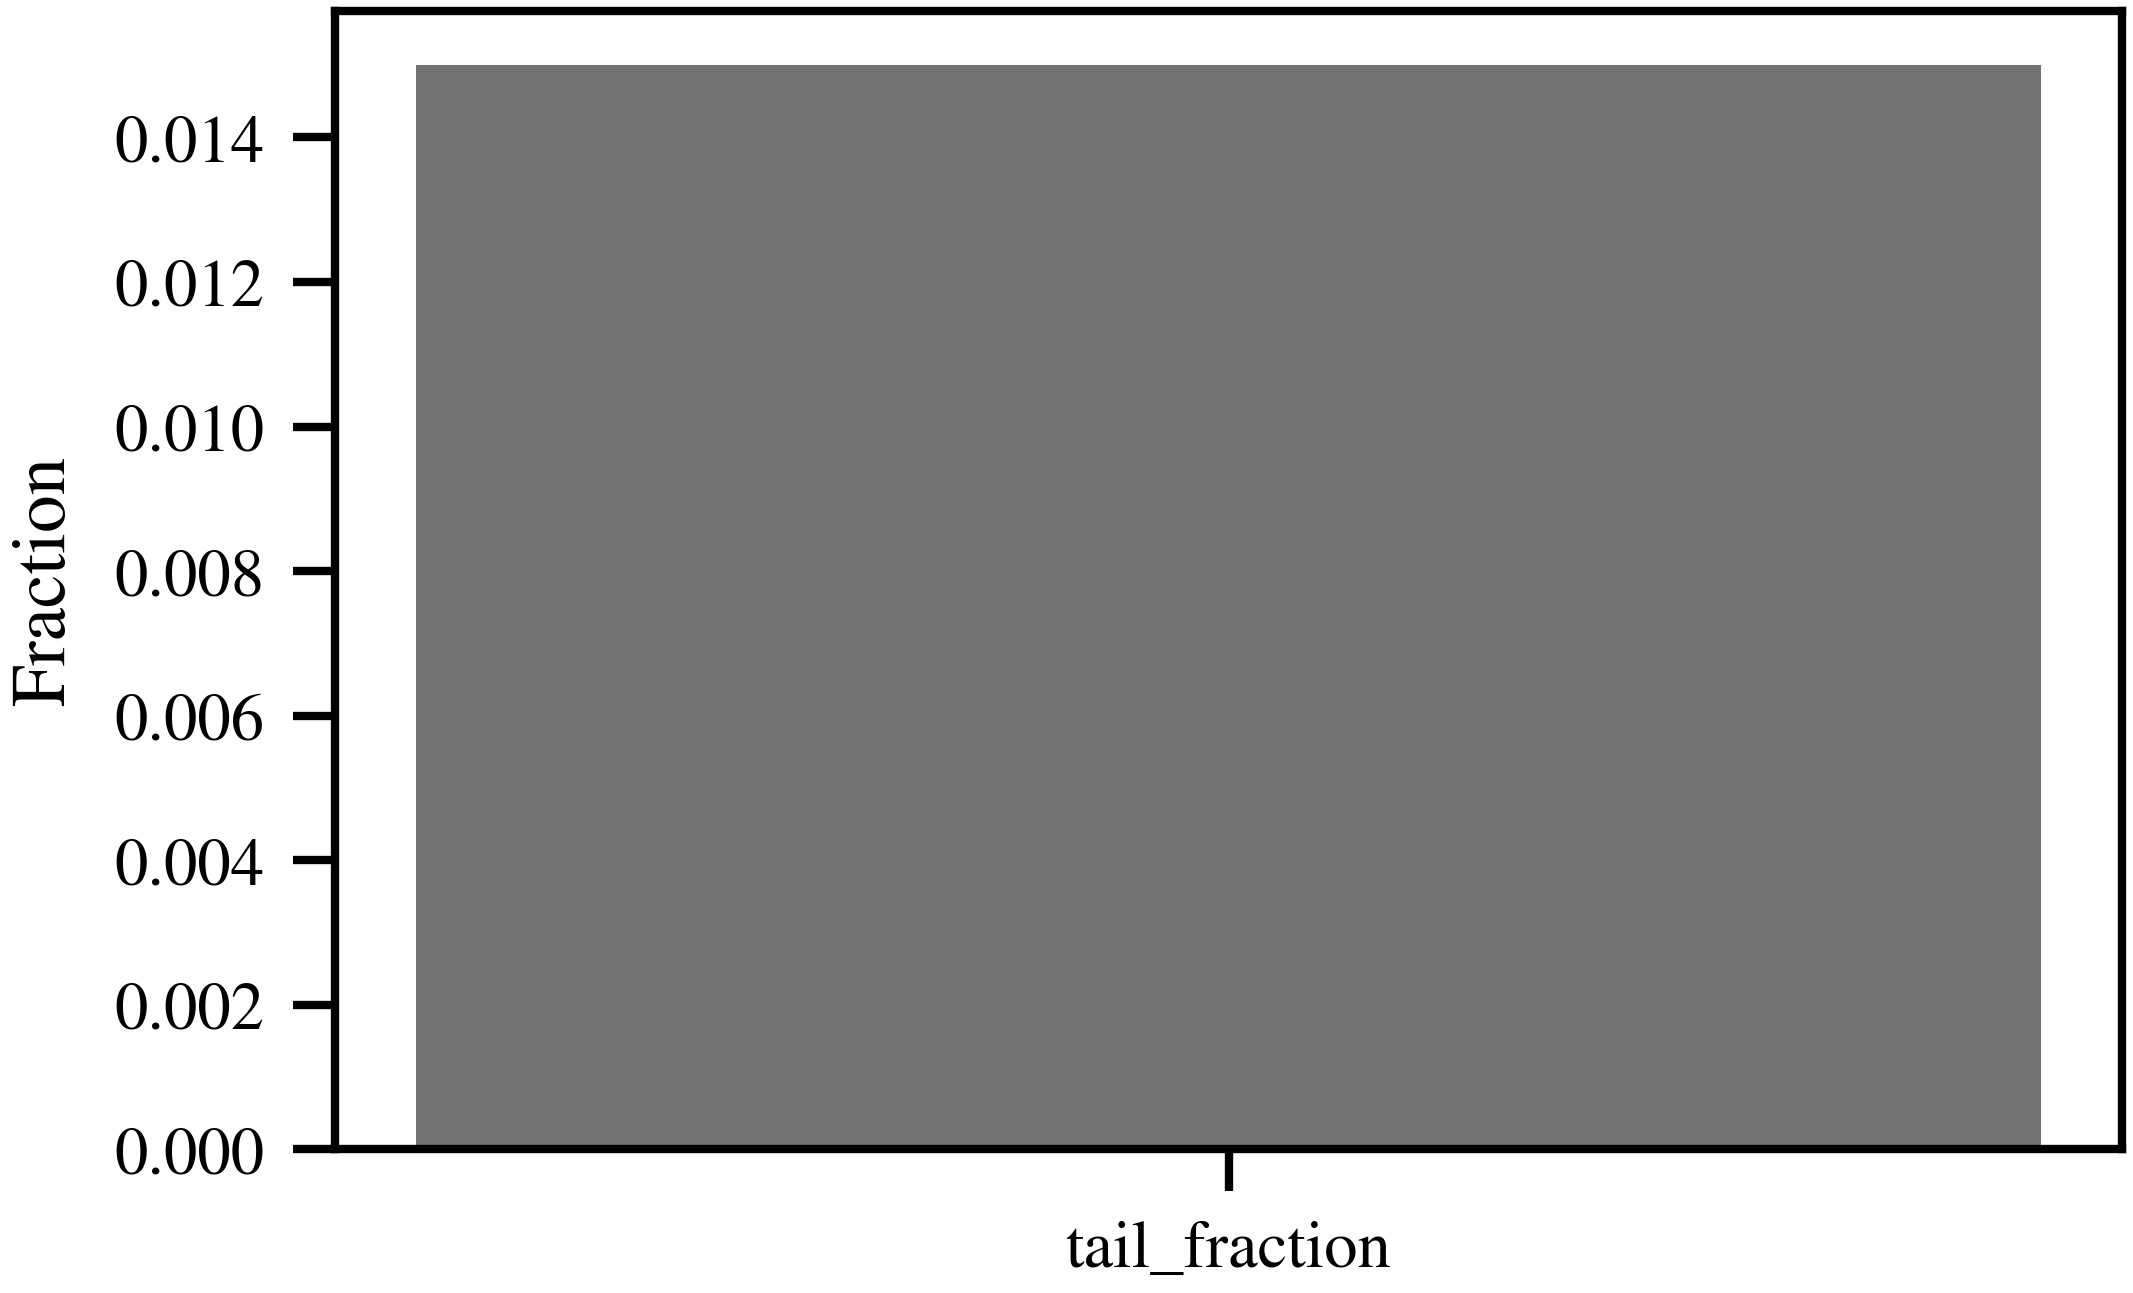

In [7]:
set_style()
spec = paper_figspec(column="single", aspect=0.55)
with journal_style():
    fig_custom, ax = new_figure(spec)
    ax.plot(
        np.arange(len(time_stats["ess"])),
        time_stats["ess"],
        marker="o",
        color="0.25",
    )
    ax.set_xlabel("Time step")
    ax.set_ylabel("ESS")
    apply_axes_style(ax)

spec_alt = FigureSpec(width_in=3.6, height_in=2.2)
with paper_context():
    fig_alt, ax_alt = new_figure(spec_alt)
    ax_alt.bar(["tail_fraction"], [tail_stats["tail_fraction"]], color="0.45")
    ax_alt.set_ylabel("Fraction")
    apply_axes_style(ax_alt)

fig_custom, fig_alt

In [8]:
output_dir = Path("docs/assets/figures")
output_dir.mkdir(parents=True, exist_ok=True)
save_figure(fig_overlap, output_dir / "diagnostics_overlap")
save_figure(fig_ess, output_dir / "diagnostics_ess")
save_figure(fig_trade, output_dir / "diagnostics_bias_variance_tradeoff")
save_figure(fig_custom, output_dir / "diagnostics_custom_ess")
save_figure(fig_alt, output_dir / "diagnostics_tail_fraction")

{'pdf': 'docs/assets/figures/diagnostics_tail_fraction.pdf',
 'png': 'docs/assets/figures/diagnostics_tail_fraction.png'}